In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import joblib
import os


In [2]:
# Load dataset
df = pd.read_csv("/content/WineQT.csv")  # Change path if needed
print("Loaded", df.shape, "rows")

# Show first rows
df.head()


Loaded (1143, 13) rows


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [3]:
# Dataset information
df.info()
# Descriptive statistics
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


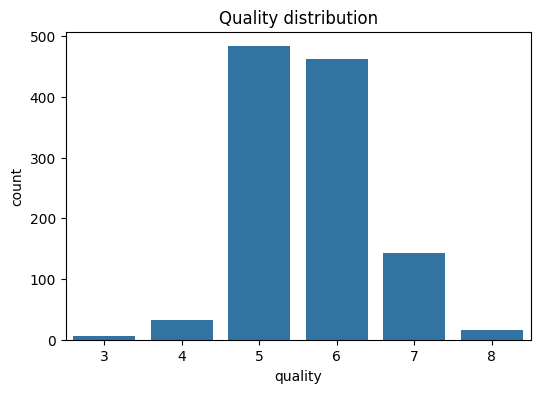

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='quality', data=df)
plt.title("Quality distribution")
plt.show()


In [5]:
# Map quality to low / medium / high
def map_quality(q):
    if q <= 4:
        return 0  # low
    elif q <= 6:
        return 1  # medium
    else:
        return 2  # high

df['quality_label'] = df['quality'].apply(map_quality)
print("Label counts:\n", df['quality_label'].value_counts())


Label counts:
 quality_label
1    945
2    159
0     39
Name: count, dtype: int64


In [6]:
# Features: drop target columns
X = df.drop(columns=['quality', 'quality_label'])

# Convert 'type' column to numeric if exists
if 'type' in X.columns:
    X = pd.get_dummies(X, columns=['type'], drop_first=True)

y = df['quality_label']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.pkl")


['models/scaler.pkl']

In [8]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name} with CV...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    print(f"{name} CV f1_macro: {scores.mean():.4f} ± {scores.std():.4f}")

    # Train on full training set
    model.fit(X_train_scaled, y_train)

    # Evaluate on test set
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    print(f"{name} test accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, target_names=['low','medium','high']))

    results[name] = {
        "model": model,
        "cv_f1_macro": scores.mean(),
        "test_accuracy": acc
    }



Training RandomForest with CV...
RandomForest CV f1_macro: 0.4829 ± 0.0206
RandomForest test accuracy: 0.9039
              precision    recall  f1-score   support

         low       0.00      0.00      0.00         8
      medium       0.91      0.98      0.94       189
        high       0.88      0.66      0.75        32

    accuracy                           0.90       229
   macro avg       0.59      0.55      0.56       229
weighted avg       0.87      0.90      0.88       229


Training GradientBoosting with CV...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


GradientBoosting CV f1_macro: 0.5367 ± 0.0438
GradientBoosting test accuracy: 0.8821
              precision    recall  f1-score   support

         low       0.00      0.00      0.00         8
      medium       0.90      0.96      0.93       189
        high       0.77      0.62      0.69        32

    accuracy                           0.88       229
   macro avg       0.56      0.53      0.54       229
weighted avg       0.85      0.88      0.86       229



In [9]:
best_name = max(results.keys(), key=lambda n: results[n]['cv_f1_macro'])
best_model = results[best_name]['model']
print(f"Best model: {best_name}")

# Save model
joblib.dump(best_model, "models/model.pkl")
print("Saved models/model.pkl and models/scaler.pkl")


Best model: GradientBoosting
Saved models/model.pkl and models/scaler.pkl


In [10]:
metrics_df = pd.DataFrame({
    name: {"cv_f1_macro": results[name]['cv_f1_macro'], "test_accuracy": results[name]['test_accuracy']}
    for name in results
}).T
metrics_df.to_csv("models/model_metrics.csv")
print("Saved models/model_metrics.csv")
metrics_df


Saved models/model_metrics.csv


,cv_f1_macro,test_accuracy
RandomForest,0.482859,0.903930
GradientBoosting,0.536696,0.882096


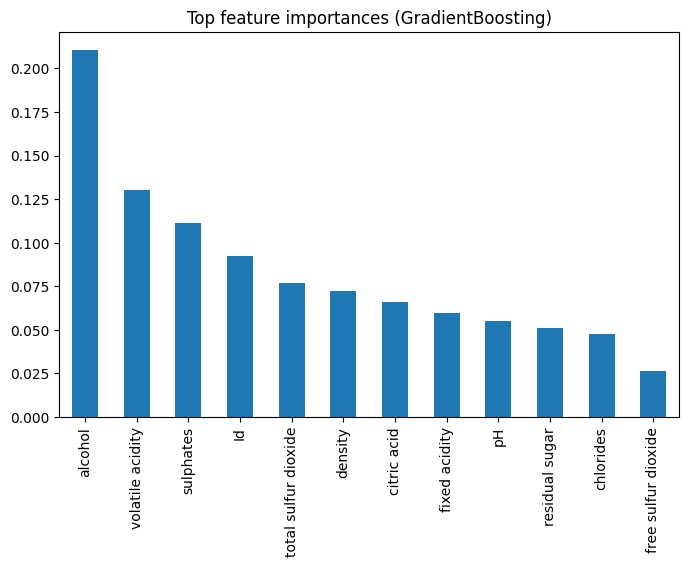

In [11]:
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feat_names = X.columns
    fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)

    plt.figure(figsize=(8,5))
    fi.head(15).plot(kind='bar')
    plt.title(f"Top feature importances ({best_name})")
    plt.show()
